# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

filepath = 'C:/Users/zbro1/Documents/GitHub/Solar-Panel-Capstone/figures/'

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_IQ6PLUS-72-ACM-US [240V],inverter_model_1_SE3800H-US (240V),inverter_model_1_SE9KUS [208V],inverter_model_1_IQ7XS-96-E-ACM-US [240V],inverter_model_1_SE7600H-US (240V),inverter_model_1_SPR-X22-360-E-AC [208V],inverter_model_1_SE11400H-US (240V),inverter_model_1_IQ7-60-x-ACM-US [208V],inverter_model_1_SE10000H-US (240V),inverter_model_1_SB3.8-1SP-US-40 [208V]
351828,5.120,0.0,0,0.0,0.0,26.0,0.0,0.0,0.197531,16.0,...,0,0,0,0,0,0,0,0,0,0
391690,5.520,0.0,0,0.0,0.0,23.0,0.0,0.0,0.209255,16.0,...,0,0,0,0,0,0,0,0,0,0
397978,13.545,0.0,0,0.0,0.0,19.0,0.0,0.0,0.194085,43.0,...,0,0,0,0,0,0,0,0,0,0
455364,3.150,0.0,0,1.0,0.0,18.0,0.0,0.0,0.194444,1.0,...,0,0,0,0,0,0,0,0,0,0
382648,8.640,0.0,0,0.0,0.0,30.0,0.0,0.0,0.198895,24.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train.shape, y_train.shape

((156192, 400), (156192, 1))

In [5]:
X_train.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US [240V]',
       'inverter_model_1_SE3800H-US (240V)', 'inverter_model_1_SE9KUS [208V]',
       'inverter_model_1_IQ7XS-96-E-ACM-US [240V]',
       'inverter_model_1_SE7600H-US (240V)',
       'inverter_model_1_SPR-X22-360-E-AC [208V]',
       'inverter_model_1_SE11400H-US (240V)',
       'inverter_model_1_IQ7-60-x-ACM-US [208V]',
       'inverter_model_1_SE10000H-US (240V)',
       'inverter_model_1_SB3.8-1SP-US-40 [208V]'],
      dtype='object', length=400)

To start I'm going to train-test split the data to quickly work through models using just 10% of the data for training to get a feel for which models perform the best, from there I'll focus on improving the best model with more data.

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.9, random_state=20)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((15619, 400), (140573, 400), (15619, 1), (140573, 1))

In [7]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. I'll run 60 iterations of each since the small amount of data should help run the code fairly quickly. I'm going to score my models based on root mean squared error (RMSE) to make sure that I'm holding them accountable for hitting outliers accurately.

In [8]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_squared_error(y_te, y_pred)}
print(mean_squared_error(y_te, y_pred))

9923409.458484394


In [9]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

9941871.826396944


In [10]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10670605.331182227


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [11]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

1.2650560958117026e+19


Next I'll run Ridge and Lasso models.

In [12]:
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 100.10739551631305}

In [13]:
#Calling the results dataframe to find the column name for the RMSE scores
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

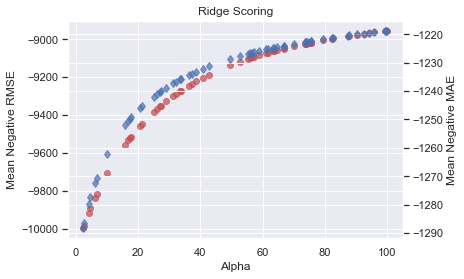

In [14]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
plt.title('Ridge Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [15]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10336555.924815075


In [16]:
parameters = {'alpha': sp_randFloat(1,100)}
lasso = linear_model.Lasso(random_state = 12)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 99.83738380592261}

In [17]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028B7D2F3C88> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028B7D059888> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':


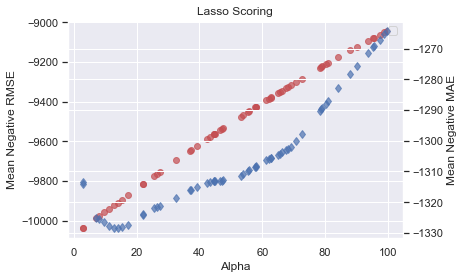

In [18]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

plt.title('Lasso Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [19]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10155465.835271405


Next will be random forest regression.

In [20]:
parameters = {'max_features': sp_randFloat(0.35, 0.48),
             'max_depth': sp_randInt(6,12),
             'min_samples_leaf': sp_randInt(580,780),
             'n_estimators': sp_randInt(900,1100)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 6,
 'max_features': 0.3958257216631382,
 'min_samples_leaf': 653,
 'n_estimators': 1092}

In [21]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9720312.156255372

I'll take a look at XGBoost next to see if it can improve even further. First I need to clean up the column names since XGBoost can't work with some characters. Then I'll run three XGBoost models, one using tree boosters, one using a linear booster with shotgun algorithm, and one using a linear booster with coordinate descent algorithm. 

In [22]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [23]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
xgbooster.best_params_

{'colsample_bytree': 0.011628310182469744,
 'eta': 0.0711158647674193,
 'max_depth': 9,
 'n_estimators': 860}

In [24]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

11759799.794647824

In [25]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'shuffle',
 'reg_alpha': 0.027907788861532556,
 'reg_lambda': 0.3001700598239866}

In [26]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Shotgun'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9788440.0970082

In [27]:
xgb_coord_desc = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_cd = RandomizedSearchCV(xgb_coord_desc, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear_cd = rand_xgb_cd.fit(x_tr, y_tr)
xgbooster_linear_cd.best_params_

{'feature_selector': 'greedy',
 'reg_alpha': 0.16257188749185125,
 'reg_lambda': 0.22879975280633458}

In [28]:
xgb_model_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_lcd.fit(x_tr, y_tr)
y_pred = xgb_model_lcd.predict(x_te)
train_scores['XGBoost Linear Coord Descent'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9789561.7792491

Next will be a more basic decision tree.

In [29]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

{'max_depth': 3, 'min_samples_leaf': 3944}

In [30]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9865568.682526754

Finally I'll look at K nearest neighbors and then LGBM

In [31]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

{'n_neighbors': 29}

In [32]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

11856353.022411231

In [33]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
opt_lgbm.best_params_

{'learning_rate': 0.0069093558684842895,
 'max_depth': 4,
 'n_estimators': 852,
 'num_leaves': 106}

In [34]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

23385497.30930615

Now that I've done a quick once-over for these different models let's take a look at which performed the best so far and by how much.

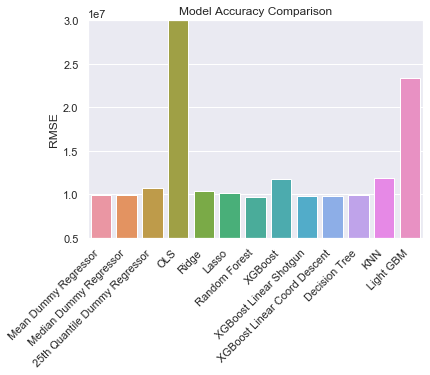

In [146]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.ylim(5000000,30000000)
plt.title('Model Accuracy Comparison')
plt.savefig(filepath+'accuracy_comparison_1', dpi=1200, bbox_inches='tight')
plt.show()

I'll also list out the values in order.

In [36]:
[(k, v) for k, v in sorted(train_scores.items(), key=lambda x: x[1], reverse=False)]

[('Random Forest', 9720312.156255372),
 ('XGBoost Linear Shotgun', 9788440.0970082),
 ('XGBoost Linear Coord Descent', 9789561.7792491),
 ('Decision Tree', 9865568.682526754),
 ('Mean Dummy Regressor', 9923409.458484394),
 ('Median Dummy Regressor', 9941871.826396944),
 ('Lasso', 10155465.835271405),
 ('Ridge', 10336555.924815075),
 ('25th Quantile Dummy Regressor', 10670605.331182227),
 ('XGBoost', 11759799.794647824),
 ('KNN', 11856353.022411231),
 ('Light GBM', 23385497.30930615),
 ('OLS', 1.2650560958117026e+19)]

Now I need to hone in on the top few models to see which really stands out as I work on improving them. I'll start by rerunning most of them with 80% training data splits using the same hyperparameters identified in this first section.

In [37]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=20)
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((124953, 400), (31239, 400), (124953,), (31239,))

In [38]:
train_scores_2 = {}
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores_2['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

3091640.1719099325


In [39]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [40]:
xgb_model_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_lcd.fit(x_tr, y_tr)
y_pred = xgb_model_lcd.predict(x_te)
train_scores_2['XGBoost Linear Coord Descent'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3443012.457759479

In [41]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores_2['XGBoost Linear Shotgun'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3442943.5947678583

In [42]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores_2['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3652854.27803343

In [43]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores_2['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3252545.4643747206

In [44]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores_2['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3206711.3747102357

In [45]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores_2['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3461126.491013701

In [46]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores_2['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

3598885.92664813


In [47]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores_2['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3004575.1503875456

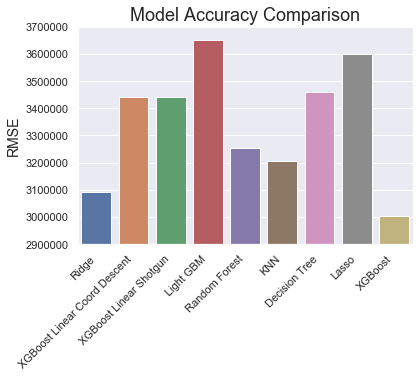

In [127]:
keys = list(train_scores_2.keys())
vals = [float(train_scores_2[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE', fontsize=14)
plt.ylim(2900000,3700000)
plt.title('Model Accuracy Comparison', fontsize=18)
plt.savefig(filepath+'accuracy_comparison', dpi=1200, bbox_inches='tight')
plt.show()

Wow, ridge is holding up as one of the best models we have for this data! I'll redo the hyperparameter tuning at this higher train-test split on just ridge, XGBoost, and KNN to try to improve them and see if I can further narrow down to a single model worth finalizing. To try to improve my computing times I'll take a look at the XGBoost tuning results from earlier to see if there are any that I am confident that I've optimized. If so I'll remove them from my next search and hold them constant.

In [49]:
xgb_params = pd.DataFrame(xgbooster.cv_results_)

In [50]:
xgb_params.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_eta', 'param_max_depth',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

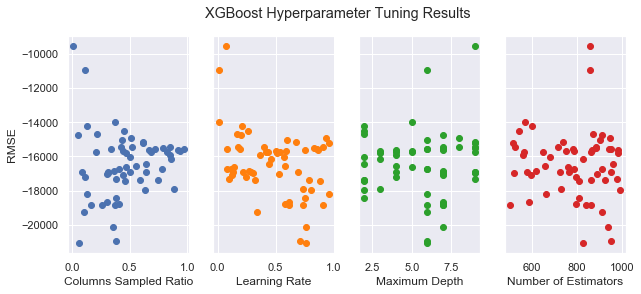

In [126]:
fig, axs = plt.subplots(1, 4, sharey=True, )
axs[0].plot(xgb_params['param_colsample_bytree'], xgb_params['mean_test_score'], ls='', marker='o')
axs[1].plot(xgb_params['param_eta'], xgb_params['mean_test_score'], 'tab:orange', ls='', marker='o')
axs[2].plot(xgb_params['param_max_depth'], xgb_params['mean_test_score'], 'tab:green', ls='', marker='o')
axs[3].plot(xgb_params['param_n_estimators'], xgb_params['mean_test_score'], 'tab:red', ls='', marker='o')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Columns Sampled Ratio')
axs[1].set_xlabel('Learning Rate')
axs[2].set_xlabel('Maximum Depth')
axs[3].set_xlabel('Number of Estimators')
fig.suptitle('XGBoost Hyperparameter Tuning Results')

fig.set_size_inches(10, 4)
plt.savefig(filepath+'xgb_hyperparameter_tuning.png', dpi=1200, bbox_inches='tight')
plt.show()

It looks like I can reduce the window for colsample_bytree and eta to get further improvement. However, there's not much variation within max_depth or n_estimators, so I'm going to hold those where they are and not include them in further random searching.

In [55]:
train_scores_3 = {}
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
y_pred = random_ridge.predict(x_te)
train_scores_3['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

3091680.831836063


In [56]:
xgb = XGBRegressor(max_depth = xgbooster.best_params_['max_depth'], n_estimators = xgbooster.best_params_['n_estimators'])
parameters = {'eta': sp_randFloat(0.0001,0.1),
             'colsample_bytree': sp_randFloat(0.01,0.2)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=15)
xgbooster_2 = rand_xgb.fit(x_tr, y_tr)
y_pred = xgbooster_2.predict(x_te)
train_scores_3['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

2956894.9436386856

Great, I got some improvement over the last XGBoost model. Now I'll do the same check of the Light GBM parameters to see if there are any I can set in stone.

In [57]:
lgbm_params = pd.DataFrame(opt_lgbm.cv_results_)

In [58]:
lgbm_params.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_num_leaves', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

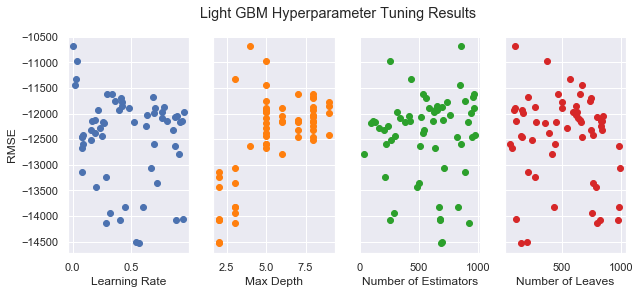

In [124]:
fig, axs = plt.subplots(1, 4, sharey=True, )
axs[0].plot(lgbm_params['param_learning_rate'], lgbm_params['mean_test_neg_root_mean_squared_error'], ls='', marker='o')
axs[1].plot(lgbm_params['param_max_depth'], lgbm_params['mean_test_neg_root_mean_squared_error'], 'tab:orange', ls='', marker='o')
axs[2].plot(lgbm_params['param_n_estimators'], lgbm_params['mean_test_neg_root_mean_squared_error'], 'tab:green', ls='', marker='o')
axs[3].plot(lgbm_params['param_num_leaves'], lgbm_params['mean_test_neg_root_mean_squared_error'], 'tab:red', ls='', marker='o')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Learning Rate')
axs[1].set_xlabel('Max Depth')
axs[2].set_xlabel('Number of Estimators')
axs[3].set_xlabel('Number of Leaves')
fig.suptitle('Light GBM Hyperparameter Tuning Results')

fig.set_size_inches(10, 4)
plt.savefig(filepath+'lgbm_hyperparameter_tuning.png', dpi=1200, bbox_inches='tight')
plt.show()

Looking at these, n_estimators and num_leaves both seem to have little impact on the RMSE, so I'll lock them. Max depth seems to peak around 4 so I'll narrow that window, and learning rate seems to peak at lower values so I'll narrow that window as well.

In [63]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mse', n_estimators = opt_lgbm.best_params_['n_estimators'],\
                         num_leaves = opt_lgbm.best_params_['num_leaves'])
parameters = {'max_depth': sp_randInt(3,5),
              'learning_rate': sp_randFloat(0.0001,0.1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm_2 = rand_lgbm.fit(x_tr, y_tr)
y_pred = opt_lgbm_2.predict(x_te)
train_scores_3['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3368329.290022728

In [64]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=30, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
y_pred = opt_nn.predict(x_te)
train_scores_3['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

3206764.843569507

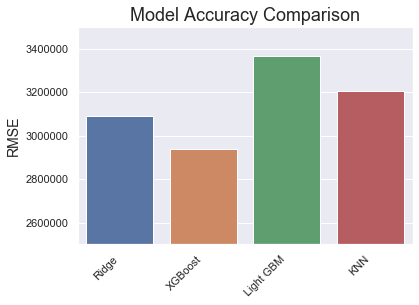

In [129]:
keys = list(train_scores_3.keys())
vals = [float(train_scores_3[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE', fontsize=14)
plt.ylim(2500000,3500000)
plt.title('Model Accuracy Comparison', fontsize=18)
plt.savefig(filepath+'final_comparison', dpi=1200, bbox_inches='tight')
plt.show()

So it looks like ridge plateaus around 3.1M RMSE and we're safe to stop pushing it any further. XGBoost performs the best of the four. I will go ahead and take a look now at XGBoost to see if I hold these hyperparameters but add extra data to the train set will it significantly boost the performance at all.

In [66]:
xgb_parameters = {'eta': xgbooster_2.best_params_['eta'],
                  'colsample_bytree': xgbooster_2.best_params_['colsample_bytree'],
                  'max_depth': xgbooster.best_params_['max_depth'],
                  'n_estimators': xgbooster.best_params_['n_estimators']}
xgb_parameters

{'eta': 0.02508990138801145,
 'colsample_bytree': 0.032348255235118945,
 'max_depth': 9,
 'n_estimators': 860}

In [67]:
print(os.getcwd())
os.chdir(r"..\..\models")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\models


In [68]:
xgbooster_2.best_estimator_.save_model('xgboost_intermediate.txt')

In [69]:
X_train.columns = X_train.columns.str.replace('[', '_')
X_train.columns = X_train.columns.str.replace(']', '_')
X_train.columns = X_train.columns.str.replace(' ', '_')
X_train.columns = X_train.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [70]:
split_ratios = {}

ratios = [0.2, 0.175, 0.15, 0.125, 0.1, 0.075, 0.05]

for ratio in ratios:
    x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = ratio, random_state=20)
    y_tra = y_tra.values.ravel()
    y_test = y_test.values.ravel()
    
    xgb = XGBRegressor(n_estimators = xgbooster.best_params_['n_estimators'], 
                       max_depth = xgbooster.best_params_['max_depth'], 
                       eta = xgbooster_2.best_params_['eta'],
                  colsample_bytree = xgbooster_2.best_params_['colsample_bytree']) 
    xgb.fit(x_train, y_tra)
    y_pred = xgb.predict(x_test)
    
    split_ratios[ratio] = mean_squared_error(y_test, y_pred)

In [71]:
splits = pd.DataFrame(data = split_ratios, index=['RMSE']).T

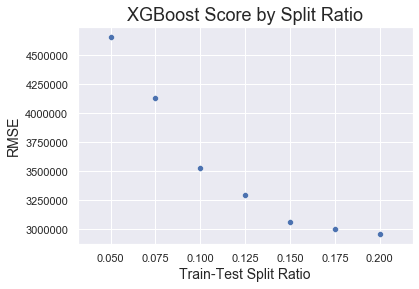

The lowest RMSE achieved was:  2956894.9436386856
The split ratio for this RSME was:  RMSE    0.2
dtype: float64


In [130]:
sns.scatterplot(data = splits, x=splits.index, y=splits['RMSE'])
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Train-Test Split Ratio', fontsize=14)
plt.title('XGBoost Score by Split Ratio', fontsize=18)
plt.savefig(filepath+'test_train_splits', dpi=1200, bbox_inches='tight')
plt.show()
print('The lowest RMSE achieved was: ', min(splits['RMSE']))
print('The split ratio for this RSME was: ', splits[['RMSE']].idxmin())

Well that's not what I expected. I expected to see a downward trend with an elbow where more data doesn't improve the score any further. This is the complete opposite trend. I'll stick with 80% train data for the remainder of this notebook. Since ridge regression gives me good results, I'll see if limiting the features to only those left in my best ridge model will help to improve the XGBoost model.

In [73]:
from sklearn.feature_selection import SelectFromModel

In [74]:
x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=20)

selector = SelectFromModel(estimator = Ridge(alpha = random_ridge.best_params_['alpha'], random_state = 12)).fit(x_train, y_tra)

In [75]:
X_train_ridge = X_train.loc[:, selector.get_support()]
X_train_ridge.shape

(156192, 143)

In [76]:
xgb_r = XGBRegressor()
parameters = {'n_estimators': sp_randInt(820,900),
             'max_depth': sp_randInt(8,10),
             'eta': sp_randFloat(0.0001,0.05),
             'colsample_bytree': sp_randFloat(0.01,0.05)} 
ridge_xgb = RandomizedSearchCV(xgb_r, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbr = ridge_xgb.fit(x_train, y_tra)
y_pred = xgbr.predict(x_test)
train_scores_3['XGBoost'] = mean_squared_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

2939315.1135407845

In [77]:
rmse_dict = {'ridge_data_rmse': mean_squared_error(y_test, y_pred), 'full_data_rmse': min(splits['RMSE'])}

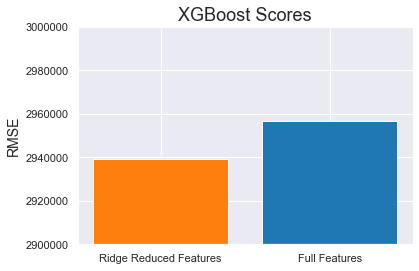

In [147]:
plt.bar(range(len(rmse_dict)), list(rmse_dict.values()), tick_label=['Ridge Reduced Features', 'Full Features'],\
        color=['tab:orange', 'tab:blue'])
plt.ylabel('RMSE', fontsize=14)
plt.ylim(2900000, 3000000)
plt.title('XGBoost Scores', fontsize=18)
plt.savefig(filepath+'full_v_reduced', dpi=1200, bbox_inches='tight')
plt.show()

These results are very close. To wrap up I'll perform the final training of both models on the full X_train dataset (reduced with only the ridge features), then test them on the separate X_test set that I haven't loaded yet. Then I'll take a look at feature importance in the models based on the full data to see how they align with what I identified during exploratory data analysis.

In [79]:
print('n_estimators: ', xgbr.best_params_['n_estimators'])
print('max_depth: ', xgbr.best_params_['max_depth'])
print('eta: ', xgbr.best_params_['eta'])
print('colsample_bytree: ', xgbr.best_params_['colsample_bytree'])

n_estimators:  832
max_depth:  8
eta:  0.018993798853917804
colsample_bytree:  0.04390584855431003


In [80]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\models
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [81]:
x_train_final = pd.read_csv('X_train.csv', index_col=0)
x_test_final = pd.read_csv('X_test.csv', index_col=0)
y_train_final = pd.read_csv('y_train.csv', index_col=0)
y_test_final = pd.read_csv('y_test.csv', index_col=0)

In [82]:
y_train_final = y_train_final.values.ravel()
y_test_final = y_test_final.values.ravel()

In [83]:
x_train_final.columns = x_train_final.columns.str.replace('[', '_')
x_train_final.columns = x_train_final.columns.str.replace(']', '_')
x_train_final.columns = x_train_final.columns.str.replace(' ', '_')
x_train_final.columns = x_train_final.columns.str.replace(',', '_')
x_test_final.columns = x_test_final.columns.str.replace('[', '_')
x_test_final.columns = x_test_final.columns.str.replace(']', '_')
x_test_final.columns = x_test_final.columns.str.replace(' ', '_')
x_test_final.columns = x_test_final.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [84]:
booster_final = XGBRegressor(n_estimators = xgbr.best_params_['n_estimators'],
                      max_depth = xgbr.best_params_['max_depth'],
                      eta = xgbr.best_params_['eta'],
                      colsample_bytree = xgbr.best_params_['colsample_bytree']).fit(x_train_final, y_train_final)
y_pred_final = booster_final.predict(x_test_final)
mean_squared_error(y_test_final, y_pred_final)

35030493.060057156

Ouch, that's a very dramatic increase in RMSE compared to my prior training. Let's see if the model based on the full 400 features performs any better. 

In [85]:
booster_final_full = XGBRegressor(n_estimators = xgbooster.best_params_['n_estimators'],
                      max_depth = xgbooster.best_params_['max_depth'],
                      eta = xgbooster_2.best_params_['eta'],
                      colsample_bytree = xgbooster_2.best_params_['colsample_bytree']).fit(x_train_final, y_train_final)
y_pred_final_full = booster_final_full.predict(x_test_final)
mean_squared_error(y_test_final, y_pred_final_full)

35050786.700585015

Wow, shockingly close results between the two models. I'll plot the predicted vs actual values for both models to see if there are any outliers that were particularly far off.

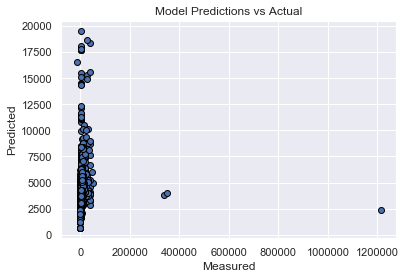

In [86]:
fig, ax = plt.subplots()
ax.scatter(y_test_final, y_pred_final, edgecolors=(0, 0, 0))
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Model Predictions vs Actual')
plt.show()

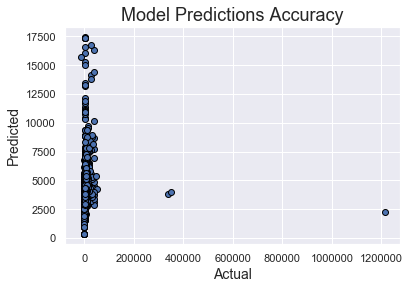

In [133]:
fig, ax = plt.subplots()
ax.scatter(y_test_final, y_pred_final_full, edgecolors=(0, 0, 0))
ax.set_xlabel('Actual', fontsize=14)
ax.set_ylabel('Predicted', fontsize=14)
plt.title('Model Predictions Accuracy', fontsize=18)
plt.savefig(filepath+'prediction_accuracy', dpi=1200, bbox_inches='tight')
plt.show()

As expected, it looks like there are three points in the test set that are very poorly predicted by both models. I'll identify which points these are, then try to identify why the price per KW for them is so much higher than the rest of the dataset.

In [88]:
diff = np.array((y_test_final - y_pred_final_full) > 100000)

In [136]:
y_t_f_df = pd.DataFrame(y_test_final)
x_outliers = x_test_final.loc[diff]
y_outliers = y_t_f_df.loc[diff]
x_outliers

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_IQ6PLUS-72-ACM-US__240V_,inverter_model_1_SE3800H-US_(240V),inverter_model_1_SE9KUS__208V_,inverter_model_1_IQ7XS-96-E-ACM-US__240V_,inverter_model_1_SE7600H-US_(240V),inverter_model_1_SPR-X22-360-E-AC__208V_,inverter_model_1_SE11400H-US_(240V),inverter_model_1_IQ7-60-x-ACM-US__208V_,inverter_model_1_SE10000H-US_(240V),inverter_model_1_SB3.8-1SP-US-40__208V_
134435,10.08,0.0,0,0.0,0.0,18.0,0.0,0.0,0.198895,28.0,...,0,0,0,0,0,0,0,0,0,0
2022447,7.54,0.0,0,0.0,0.0,18.0,0.0,0.0,0.197531,1.0,...,0,0,0,0,0,0,0,0,0,0
1840658,6.80,1476.0,0,0.0,0.0,18.0,0.0,0.0,0.196078,1.0,...,0,0,0,0,0,0,0,0,0,0


Now that I have the original indices of the outlier points I'll pull back the original wrangled dataset to see if I can identify any fields that stand out as the possible difference.

In [135]:
os.chdir(r"..\interim")
original_data = pd.read_csv('wrangled_data.csv', index_col=0)

C:\Users\zbro1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [137]:
original_data.loc[[134435, 2022447, 1840658],].T

,134435,2022447,1840658
data_provider_1,Salt River Project,Utah Office of Energy Development,New York State Energy Research and Development...
system_id_1,50806,SolarPV--0000002563,253904
installation_date,2020-03-30,2020-07-01,2020-08-07
system_size_dc,10.08,7.54,6.8
total_installed_price,3427200.0,2631400.0,8255000.0
rebate_or_grant,0.0,0.0,1476.0
customer_segment,RES,RES,RES
expansion_system,0,0,0
multiple_phase_system,0,0,0
tracking,-1,-1,-1


Total installed price is extremely high for these, but the system size is reasonable. It seems likely to me that maybe there are two extra zeroes added to each price, but I'll pull the first five entries just to compare

In [138]:
original_data.head().T

,108019,108020,108142,108175,108233
data_provider_1,Arizona Public Service,Arizona Public Service,Arizona Public Service,Arizona Public Service,Arizona Public Service
system_id_1,107903,107904,108026,108059,108117
installation_date,2020-06-17,2020-06-17,2020-06-19,2020-06-22,2020-06-23
system_size_dc,5.76,8.75,4.725,3.55,5.85
total_installed_price,17488.26,22631.0,18972.0,9900.0,20475.0
rebate_or_grant,0.0,0.0,0.0,0.0,0.0
customer_segment,RES,RES,RES,RES,RES
expansion_system,0,0,0,0,0
multiple_phase_system,0,0,0,0,0
tracking,-1,-1,-1,-1,-1


Based on this comparison it appears to me that those three outliers are most likely a typo which added extra zeroes to the price of the installation. That said, I don't have any way to verify this by looking into the individual installations. What I can say is that their systems range from 6.8-10.1 KW, which is 1-2x the size of the other five samples pulled, but the installed prices are over 100x higher. 

I am now going to re-test the model, this time without the outliers to check the RMSE and see if it's any good.

In [148]:
x_test_no_out = x_test_final.drop(index=[134435, 2022447, 1840658])

In [152]:
len(y_test_final)

52065

In [153]:
y_test_no_out = y_test_final[np.invert(diff)]

In [155]:
y_pred_no_out = booster_final_full.predict(x_test_no_out)
mean_squared_error(y_test_no_out, y_pred_no_out)

2403381.1521129967

And just for good measure, one last check of a dummy model to make sure that my model is actually an improvement.

In [156]:
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_train_final, y_train_final)
y_pred_no_out = dummy_mean.predict(x_test_no_out)
mean_squared_error(y_test_no_out, y_pred_no_out)

3091531.6395841725

Great! that's what I was hoping to see. It does seem that the model performs better without those outliers, and it beats the mean dummy regressor.

## Conclusions

First I'll check the features pulled out from the model with access to the full dataset.

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


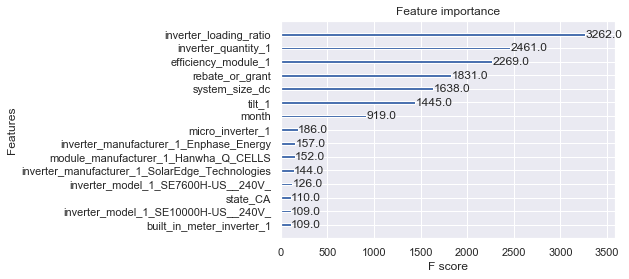

In [144]:
xgboost.plot_importance(booster = xgbooster_2.best_estimator_, max_num_features = 15)
ax.figure.tight_layout()
ax.figure.savefig(filepath+'importances', dpi=1200)

This is very interesting, it looks like most of the top features used in this XGBoost model are related to the inverter - specifically the loading ratio, manufacturer, and model. Let's see what was most important to the ridge-reduced model.

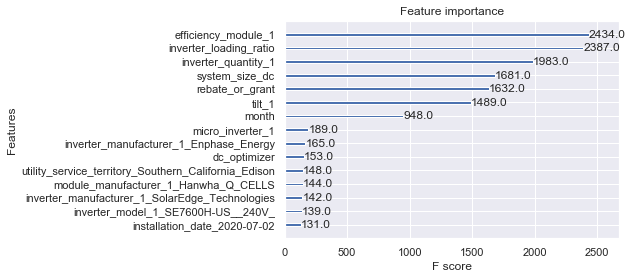

In [141]:
xgboost.plot_importance(booster = booster_final, max_num_features = 15)

This is interesting. The features most important in the reduced dataset were specific zip codes, models, installers, etc. Perhaps most important to note: the model with access to the full data used the most important features over 900 times each, whereas the reduced dataset model only used any given feature up to 79 times. Since we will have access to the full 400 features for any new data, and there's no appreciable improvement from reducing the number of features, I'll focus on the first model and explore those features in depth.

As mentioned earlier, inverter loading ratio was the most important feature, and revisiting my exploratory data analysis shows that there was a significant negative correlation between inverter loading ratio and price per KW.

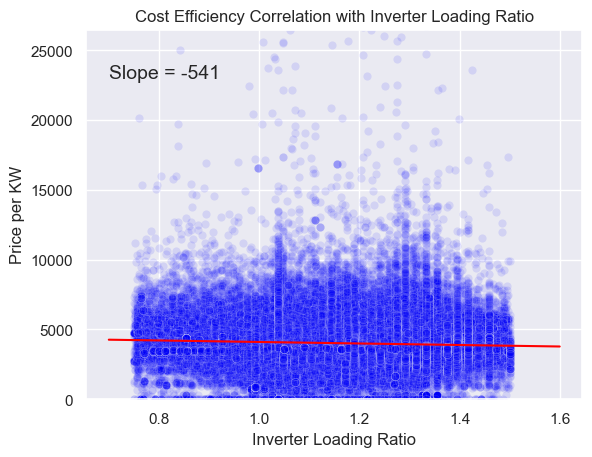

The inverter loading ratio represents the maximum amount of DC current produced by the solar panels - directly correlated to the area of panels installed - vs the AC inverter capacity. Since solar energy is produced as DC current, the inverter is needed to transform that to AC so it can be used on the US power grid. Since the panels will only experience peak performance for a brief window during the day, it is common to install more panels than the inverter can handle at peak (called inverter clipping), so that during off hours those extra panels can still contribute. A diagram below shows this concept more clearly:
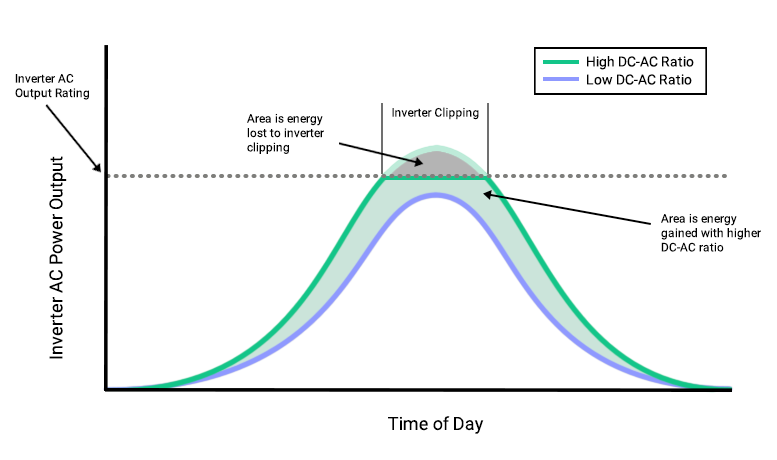
Source: https://aurorasolar.com/blog/choosing-the-right-size-inverter-for-your-solar-design-a-primer-on-inverter-clipping/

By installing a higher inverter loading ratio, the customer will produce more solar electricity throughout the day while keeping their inverter cost down, so it makes sense that this has a large impact on the overall cost efficiency of an installation.

The next most important feature was whether a rebate or grant was obtained which makes obvious sense given that applying a rebate or grant will directly lower the cost of the installation and hence improve cost efficiency.

The efficiency of the photovoltaic module was the next most important feature, which I find interesting because it seemed to have a relatively small (though significant) impact on cost efficiency. As shown in the image from my exploratory data analysis, the slope is very slightly positive, suggesting that as efficiency of the module increases, cost per KW increases as well, hurting cost efficiency.
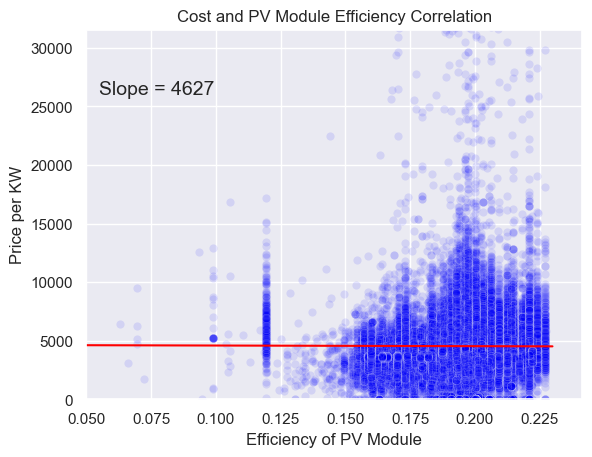

Inverter quantity 1 was the next most important feature, showing a clear correlation between larger inverters and lower cost per KW.
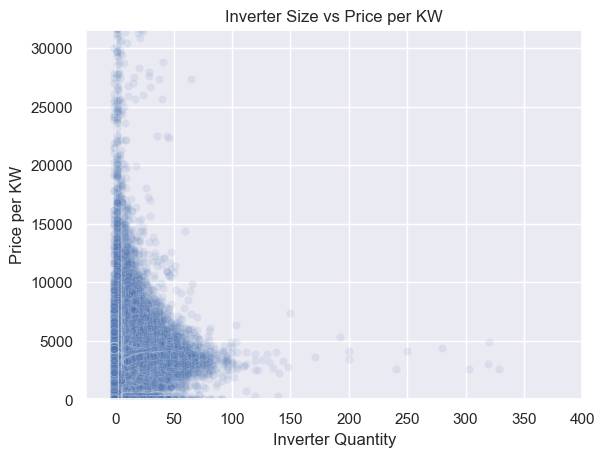

This is interesting because when taken along with the inverter ratio findings it suggests that to optimize cost efficiency the customer wants a large inverter with even more solar panels than that inverter can handle.

Tilt is an interesting feature. Tilt refers to the angle of the panel relative to the ground as shown here:
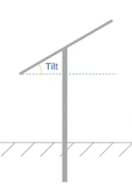
Source: https://ratedpower.com/blog/pv-panel-tilt/

What makes this feature interesting is that there are some commonly used angles which have much larger ranges of cost efficiency than the uncommonly used angles.
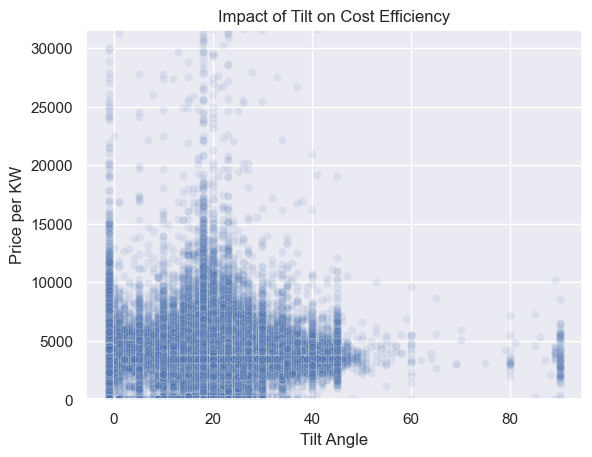

Does this mean that if you install your solar panel tilted at 7&deg; rather than 10&deg; your solar panel installation will be cheaper? I doubt it. There's likely some correlation between tilt and another factor not captured in my dataset that explains this observation, possibly even just that there are more installations at those major angles which provides more opportunity for high price per KW values to occur. 

System size was the next most important feature and much like inverter size, shows a correlation between larger system size and lower cost per KW.
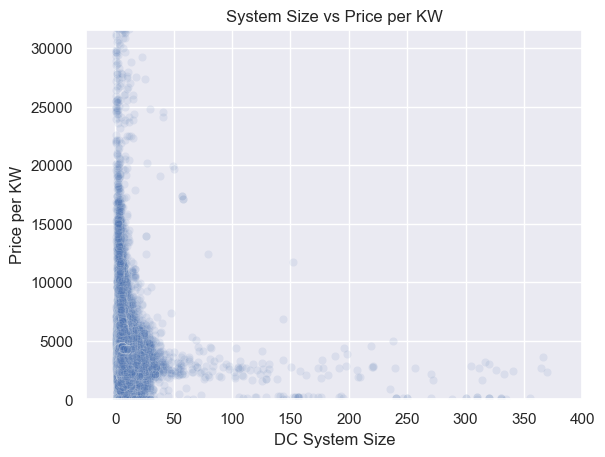

The last feature that was used for more than 100 splits in the boosted algorithm was the month of installation. Chi squared testing showed significant correlation between month and cost efficiency, and a visual representation of the data is shown below:
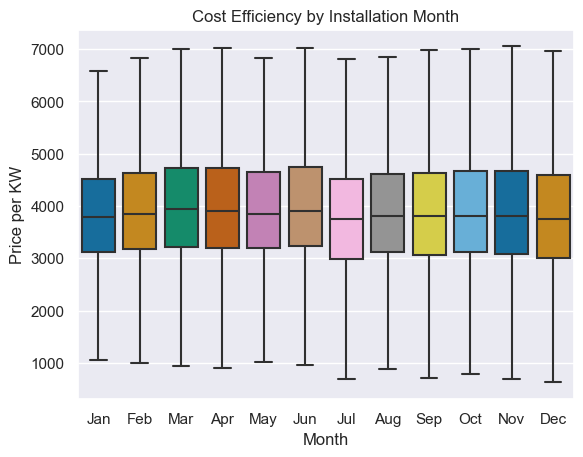

A quick look suggests that installations in July and December may be cheaper on average than other months and could save the customer some money.

Last but not least, I'll save the model so that it can be easily recalled in the future.

In [142]:
print(os.getcwd())
os.chdir(r"..\..\models")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\interim
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\models


In [ ]:
booster_final_full.save_model('xgboost_final.txt')